### Initialize libraries

In [624]:
%matplotlib inline

from __future__ import division

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import PatchCollection
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb
import time

### Initialize Model Constants

In [625]:
RJupiter = 6.99e9                 # radius of Jupiter, cm
mJupiter = 1.898e30               # mass of Jupiter, grams
v = 1e-3                           # damping coefficient
gamma = 2                         # polytrope index
G = 6.67e-8                       # dyne*cm^2/g^2
rhoC = 5                          # g/cm^3, central density
K = 5*2.6e12                        # dyne*cm^4/g^2
alpha = np.sqrt(K/(2*np.pi*G))    # distribution constant
h = 2.5e9                           # smoothing length, 5.5e8 gives nice clumping
                                  # 5.5e9 gives collapse to center
                                  # 5e9 is paper's recommended value
N1 = 100                           # Particles in planet 1

### Initialize Radial Position of Planets

In [626]:
# # Use partition to give initial radial positions of particles
# partitionNum = 5     
# rSpace = np.linspace(0, RJupiter, partitionNum)
# zetaSpace = rSpace/alpha

# # Establish number of particles in each region of delta(zeta)
# NDistribution = []    
# for i in range(1,len(zetaSpace)):
#     zeta2 = zetaSpace[i]
#     zeta1 = zetaSpace[i-1]
#     NDistribution.append((np.sin(zeta2) - zeta2*np.cos(zeta2) - np.sin(zeta1) + zeta1*np.cos(zeta1))\
#                          *N1/np.pi)
    
# NDistribution = np.array(NDistribution)
# NDistribution = np.round(NDistribution)

# # Create radial distribution
# radiusDistribution = []
# i = 0
# for N in NDistribution:
#     radiusDistribution.append(np.random.uniform(rSpace[i], rSpace[i+1], size=N))
#     i += 1
    
# # Flatten radial array
# radiusDistribution = [item for sublist in radiusDistribution for item in sublist]
# radiusDistribution = np.array(radiusDistribution)

# # Create angle distribution
# thetaDistribution = np.random.uniform(0, 2*np.pi, size=len(radiusDistribution))

# # Ballpark estimate for h, according to Monaghan 1977
# # ballpark_h = np.sqrt(np.mean(cdist(xyDistribution, xyDistribution)**2) - np.mean(cdist(xyDistribution**2, xyDistribution**2)))


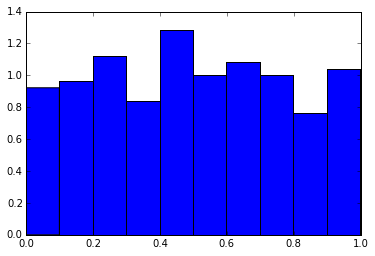

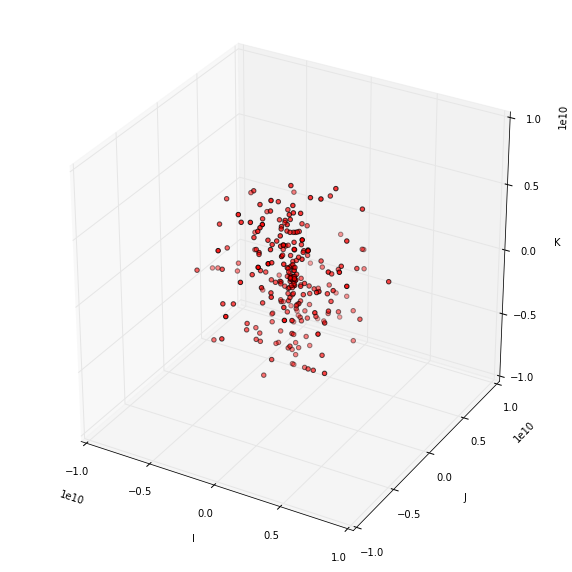

In [627]:
nParticles = 250
lower, upper = 0, 1
mu, sigma = 0, 2
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
plt.hist(X.rvs(nParticles), normed=True)

radiusDistribution = X.rvs(nParticles) * RJupiter
thetaDistribution = np.random.uniform(0, 2*np.pi, size=nParticles)
phiDistribution = np.random.uniform(0,np.pi, size=nParticles)


fig_0 = plt.figure(figsize=(10,10))
ax_0 = fig_0.add_subplot(111, projection='3d')

plt.xlim(-1e10,1e10)
plt.ylim(-1e10,1e10)
ax_0.set_zlim(-1e10,1e10)
ax_0.set_xlabel('I')
ax_0.set_ylabel('J')
ax_0.set_zlabel('K')

ax_0.scatter(radiusDistribution*np.sin(phiDistribution)*np.cos(thetaDistribution), \
            radiusDistribution*np.sin(phiDistribution)*np.sin(thetaDistribution), \
            radiusDistribution*np.cos(phiDistribution), c='r')
#ax_0.title("Initial Density Distribution of Particles")


### Initialize Cartesian Position of Planets

In [628]:
def polar2cart(r, phi, theta):
    return np.array([r*np.sin(phi)*np.cos(theta), r*np.sin(phi)*np.sin(theta), r*np.cos(phi)]).T

xyzDistribution = polar2cart(radiusDistribution, phiDistribution, thetaDistribution)
nParticles = len(xyzDistribution)

### Manually override xyzDistribution

In [629]:
# xyzDistribution = np.array(([1.0e8, 1.0e8, 1.0e8], 
#                            [-1.0e8, -1.0e8, -1e08]))

### Density Update Function

In [630]:
def densityUpdate():
    
    global xyzDistribution
    global rhoDistribution
    global mDistribution

    rhoDistribution = np.zeros_like(rhoDistribution)
    # "Self-density" contribution
    for i in range(0, nParticles):
#        rhoDistribution[i] = mDistribution[i]*W(0, h)
        
        # Density contribution from other particles
        for j in range(i, nParticles):
            xdist = (xyzDistribution[i,0]-xyzDistribution[j,0])
            ydist = (xyzDistribution[i,1]-xyzDistribution[j,1])
            zdist = (xyzDistribution[i,2]-xyzDistribution[j,2])
            dist_ij = np.sqrt(xdist**2 + ydist**2 + zdist**2)
            rho_ij = mDistribution[i]*W(dist_ij, h)
            rhoDistribution[i] += rho_ij
            rhoDistribution[j] += rho_ij

### Smoothing function
Source 1: http://arxiv.org/pdf/1007.1245.pdf

Source 2: http://arxiv.org/pdf/1012.1885.pdf

\begin{equation}
\nabla W = \frac{3x(3r - 4h)}{4 \pi h^6}, \frac{3y(3r - 4h)}{4 \pi h^6} r< h
\end{equation}

\begin{equation}
\nabla W = -\frac{3x(-2h+r)^2}{4h^6 \pi r}, -\frac{3y(-2h+r)^2}{4h^6 \pi r} h < r< 2h
\end{equation}

In [631]:
def W(dist, h):
    '''
    Inputs:
        dist: a scalar distance between particles i an j
        h: smoothing length
    '''
    if dist < h:
        return 1/(np.pi*h**3) * \
               (1/4*(2-dist/h)**3 - (1-dist/h)**3)
    elif dist > 2 * h:
        return 0
    else:
        return 1/(np.pi*h**3) * (1/4*(2-dist/h)**3)

In [632]:
def gradW(xyzDist, h):
    '''
    Inputs:
        xyzDist: a [3,1] array containing the difference in [x,y,z] position
            between two particles
        h: smoothing length
    Outputs:
        a [3,1] array containing the [x,y,z] component of gradW
    '''
    
    dist = np.sqrt(xyzDist[0]**2 + xyzDist[1]**2 + xyzDist[2]**2)
    
    if dist < h:
        return np.array(
                [3*xyzDist[0]*(3*dist - 4*h)/(4*np.pi*h**6),
                 3*xyzDist[1]*(3*dist - 4*h)/(4*np.pi*h**6),
                 3*xyzDist[2]*(3*dist - 4*h)/(4*np.pi*h**6)])
    
    # 2D kernel
#         return np.array(
#               [15*xyDist[0]*(3*dist - 4*h)/(14 * np.pi * h**5),
#                15*xyDist[1]*(3*dist - 4*h)/(14 * np.pi * h**5)])
    
    elif dist > 2 * h:
        return np.array([0,0,0])
    
    else:
        return np.array(
                [-3*xyzDist[0]*(-2*h+dist)**2/(4*h**6*np.pi*dist),
                 -3*xyzDist[1]*(-2*h+dist)**2/(4*h**6*np.pi*dist),
                 -3*xyzDist[2]*(-2*h+dist)**2/(4*h**6*np.pi*dist)])
    
#         return np.array(
#                 [-15*xyDist[0]*(2*h - dist)**2/(14*h**5*np.pi*dist),
#                  -15*xyDist[1]*(2*h - dist)**2/(14*h**5*np.pi*dist)] )

In [633]:
### --- gradW test --- ###

# asd = np.linspace(1,1e10, 100)
# qwer = []
# for i in asd:
#     qwer.append(gradW([0,i], h))
    
# plt.plot(asd, qwer)

### Define Pressure Gradient

In [634]:
def gradP():
    
    gradPArray = np.zeros_like(velocityDistribution)

    for i in range(0, nParticles):
        for j in range(i, nParticles):
            
            xdist = (xyzDistribution[i,0]-xyzDistribution[j,0])
            ydist = (xyzDistribution[i,1]-xyzDistribution[j,1])
            zdist = (xyzDistribution[i,2]-xyzDistribution[j,2])
            distArr = np.array([xdist,ydist,zdist])
            
            #gradPX = mDistribution[j]/2*((pressureDistribution[i]/(rhoDistribution[i]**2))+(pressureDistribution[j]/(rhoDistribution[j]**2)))*gradW(distArr,h)[0]
            #gradPY = mDistribution[j]/2*((pressureDistribution[i]/(rhoDistribution[i]**2))+(pressureDistribution[j]/(rhoDistribution[j]**2)))*gradW(distArr,h)[1]
            
#             gradPX = mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[0]
#             gradPY = mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[1]
#             gradPZ = mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[2]
            
            grad = [mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[0], \
                   mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[1],\
                   mDistribution[j]*pressureDistribution[j]/rhoDistribution[j]*gradW(distArr,h)[2]]
        
            gradPArray[i,:] -= grad
            gradPArray[j,:] += grad
#             gradPArray[i,0] -= gradPX
#             gradPArray[i,1] -= gradPY
#             gradPArray[i,2] -= gradPZ
#             gradPArray[j,0] += gradPX
#             gradPArray[j,1] += gradPY
#             gradPArray[j,2] += gradPZ

    return gradPArray

nb_gradP = nb.autojit(gradP)

### Define gravity

In [635]:
def gravity(xyzDistribution, t):
    
    global velocityDistribution
#    global xyDistribution
    global h
    
    deltaV = np.zeros_like(xyzDistribution, dtype = np.float)
    for j in range(0, nParticles):
        for k in range(0, nParticles):
            if (k!=j):
                xdist = (xyzDistribution[j,0]-xyzDistribution[k,0])
                ydist = (xyzDistribution[j,1]-xyzDistribution[k,1])
                zdist = (xyzDistribution[j,2]-xyzDistribution[k,2])
#                 print "time step ", t
#                 print "z distance ", zdist
#                 print "y distance ", ydist
#                 print "x distance ", xdist
#                print xyDistribution
#                print "xdist:", xdist
#                print(ydist)

# X Component of Force
                if(abs(xdist)<1e8):
                    deltaV[j,0] -= 0
#                    print "X less than smoothing"
                else:
                    deltaV[j,0] += -G*mDistribution[j]*xdist/((np.sqrt(xdist**2+ydist**2+zdist**2))**3)
                #print "distance ", (np.sqrt(xdist**2+ydist**2+zdist**2))

# Y Component of Force
                if(abs(ydist)<1e8):
                    deltaV[j,1] -= 0
#                    print "Y less than smoothing"
                else:
                    deltaV[j,1] += -G*mDistribution[j]*ydist/((np.sqrt(xdist**2+ydist**2+zdist**2))**3)

# Z Component of Force
                if(abs(zdist)<1e8):
                    deltaV[j,2] -= 0
#                    print "Z less than smoothing"
                else:
                    deltaV[j,2] += -G*mDistribution[j]*zdist/((np.sqrt(xdist**2+ydist**2+zdist**2))**3)
    

    #print(deltaV)
    return deltaV

nb_gravity = nb.autojit(gravity)

### Model Initial Velocity & Density & Pressure Distribution

In [636]:
velocityDistribution = np.zeros_like(xyzDistribution)
rhoDistribution = np.zeros_like(radiusDistribution)
mDistribution = np.ones(len(radiusDistribution))*mJupiter/len(radiusDistribution)
densityUpdate()
pressureDistribution = K * rhoDistribution ** gamma

In [637]:
# plt.figure(figsize=(10,8))
# plt.scatter(radiusDistribution*np.cos(thetaDistribution), \
#             radiusDistribution*np.sin(thetaDistribution), c=rhoDistribution)
# plt.title("Initial Density Distribution of Particles")
# plt.colorbar()
# plt.show()

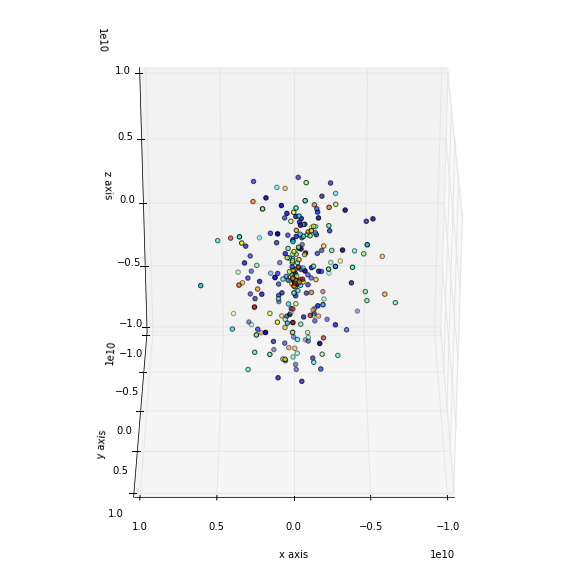

In [663]:
fig_1 = plt.figure(figsize=(10,10))
ax_1 = fig_1.add_subplot(111, projection='3d')

plt.xlim(-1e10,1e10)
plt.ylim(-1e10,1e10)
ax_1.set_zlim(-1e10,1e10)
ax_1.set_xlabel('x axis')
ax_1.set_ylabel('y axis')
ax_1.set_zlabel('z axis')
ax_1.azim=90

ax_1.scatter(radiusDistribution*np.sin(phiDistribution)*np.cos(thetaDistribution), \
            radiusDistribution*np.sin(phiDistribution)*np.sin(thetaDistribution), \
            radiusDistribution*np.cos(phiDistribution), c=rhoDistribution)

### Run through RK1
* If just pressure, run at 1e2 timestep

In [639]:
# RK1 Parameters
t0 = time.time()
t = 0
dt = 1e2
stepN = 700

# Particle history
ParticlePositionHistory = np.zeros((stepN,nParticles,3))
ParticleRhoHistory = np.zeros((stepN, nParticles, 1))
xyzDistributionOld = np.copy(xyzDistribution)

# Force history
forceHistory = np.zeros((stepN, 3))
for i in range(stepN):
    if i % 1 == 0:
        print "Time step", i
    if i == 2:
        rhoOld = np.copy(rhoDistribution)
    deltaVf = np.zeros_like(xyzDistribution, dtype = np.float)
    
    t += 1
    ParticlePositionHistory[i,:,:] = xyzDistribution
    
    deltaVf += nb_gravity(xyzDistribution,i) 
#    print "\nAvg gravity", np.mean(deltaVf)
    forceHistory[i,0] = np.mean(abs(deltaVf))
    
    deltaVf -= -nb_gradP()/rhoDistribution[:,np.newaxis]
#    print "Avg gravity + pressure", np.mean(deltaVf)
    forceHistory[i,1] = np.mean(abs(deltaVf))

    deltaVf +=  -v*velocityDistribution**1
#    print "Avg damping:", np.mean(velocityDistribution)    
    forceHistory[i,2] = np.mean(-v*velocityDistribution**1)

    
    velocityDistribution += dt*deltaVf    
    xyzDistribution += dt*velocityDistribution
    
    densityUpdate()
    ParticleRhoHistory[i,:,:] = rhoDistribution[:,np.newaxis]
    pressureDistribution = K*rhoDistribution**2

print(time.time()-t0)
#print(rhoDistribution-rhoOld)
#print(xyDistribution-xyDistributionOld) 


Time step 0
Time step 1
Time step 2
Time step 3
Time step 4
Time step 5
Time step 6
Time step 7
Time step 8
Time step 9
Time step 10
Time step 11
Time step 12
Time step 13
Time step 14
Time step 15
Time step 16
Time step 17
Time step 18
Time step 19
Time step 20
Time step 21
Time step 22
Time step 23
Time step 24
Time step 25
Time step 26
Time step 27
Time step 28
Time step 29
Time step 30
Time step 31
Time step 32
Time step 33
Time step 34
Time step 35
Time step 36
Time step 37
Time step 38
Time step 39
Time step 40
Time step 41
Time step 42
Time step 43
Time step 44
Time step 45
Time step 46
Time step 47
Time step 48
Time step 49
Time step 50
Time step 51
Time step 52
Time step 53
Time step 54
Time step 55
Time step 56
Time step 57
Time step 58
Time step 59
Time step 60
Time step 61
Time step 62
Time step 63
Time step 64
Time step 65
Time step 66
Time step 67
Time step 68
Time step 69
Time step 70
Time step 71
Time step 72
Time step 73
Time step 74
Time step 75
Time step 76
Time step

In [640]:
# slider = FloatSlider(description='Time', min=1, max=stepN, step=1)

# def update_plot():
#     time=slider.value
#     x = ParticlePositionHistory[time-1,:,0]
#     y = ParticlePositionHistory[time-1,:,1]
#     fig = plt.figure(figsize=(10,10))
#     plt.scatter(x, y, c=ParticleRhoHistory[time-1,:,:])
#     plt.xlim(-2e10, 2e10)
#     plt.ylim(-2e10, 2e10)
# #    plt.colorbar()

#     clear_output(True)

# slider.on_trait_change(update_plot, 'value')


# display(slider)
# update_plot()

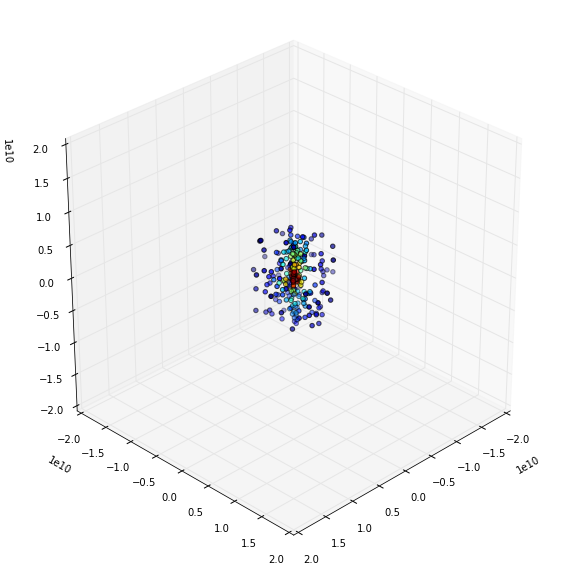

In [661]:
slider = FloatSlider(description='Time', min=1, max=stepN, step=1)

def update_plot():
    time=int(slider.value)
    x = ParticlePositionHistory[time-1,:,0]
    y = ParticlePositionHistory[time-1,:,1]
    z = ParticlePositionHistory[time-1,:,2]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=ParticleRhoHistory[time-1,:,:])
#     fig = plt.figure(figsize=(10,10))
#     plt.scatter(x, y)
    plt.xlim(-2e10,2e10)
    plt.ylim(-2e10,2e10)
    ax.set_zlim(-2e10,2e10)
    ax.azim=45

    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()

In [642]:
print(xyzDistribution-xyzDistributionOld)

[[ -2.09755381e+09   4.59916826e+09   5.34399262e+09]
 [  4.44157515e+09   1.63251766e+09  -2.39072426e+09]
 [ -4.08763019e+09  -3.31944316e+09  -2.94959718e+09]
 [  4.70751675e+09  -3.41424250e+09  -3.61862272e+09]
 [ -4.91444174e+09  -5.33096558e+09   3.01740573e+09]
 [  1.72836904e+09  -7.03334090e+09   6.42930326e+08]
 [  5.15506497e+09   1.37808330e+09  -5.53630923e+09]
 [  2.76693991e+09  -1.94548847e+09  -3.14078689e+09]
 [  3.42758197e+09  -5.00228577e+09   3.58546761e+09]
 [ -5.35784525e+08  -7.55664999e+09  -1.58526756e+09]
 [ -3.97436019e+08   1.53017260e+09  -2.68237327e+09]
 [ -2.14853403e+09   6.51973096e+09  -1.09837563e+08]
 [ -1.35631782e+09   4.49840452e+09  -4.13428948e+08]
 [  1.39161308e+09  -3.53421229e+09   4.77543262e+09]
 [  6.61099697e+09   2.86605067e+08  -4.30847449e+09]
 [ -3.13470283e+09  -2.62342541e+09  -3.64306391e+08]
 [ -6.00170233e+09  -6.01916808e+09  -8.75855084e+08]
 [  6.08170271e+09   5.00616201e+08   1.63161450e+09]
 [ -8.08709553e+08  -2.91752

[]

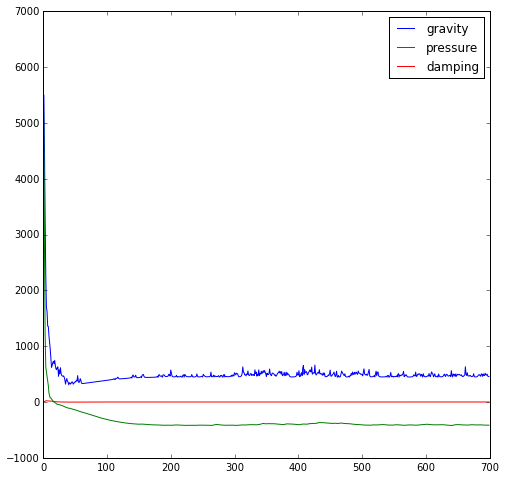

In [643]:
plt.figure(figsize=(8,8))
plt.plot(range(stepN), forceHistory[:,0], label='gravity')
plt.plot(range(stepN), forceHistory[:,1] - forceHistory[:,0], label='pressure')
plt.plot(range(stepN), forceHistory[:,2], label='damping')
#plt.plot(range(stepN), forceHistory[:,1] + forceHistory[:,2], label='net')
plt.legend()
plt.plot()

In [665]:
print ParticlePositionHistory.shape
np.save('3d_data.csv', ParticlePositionHistory)

(700, 250, 3)


In [656]:
PPH = ParticlePositionHistory.reshape([-1,250])

In [662]:
print rhoDistribution

[ 0.35955421  0.40749264  0.3503246   0.35379298  0.34383488  0.38044688
  0.35355013  0.34754679  0.37769834  0.34565377  0.36688723  0.35515437
  0.34795823  0.3729111   0.39558601  0.3591229   0.35426038  0.37232512
  0.35313737  0.36068356  0.47964107  0.50208059  0.54112646  0.3482963
  0.36372093  0.36817678  0.35880493  0.49313344  0.51535028  0.36557659
  0.56656605  0.35986673  0.6040047   0.36958816  0.44751373  0.3769822
  0.36856622  0.48861553  0.60110437  0.51456411  0.3716373   0.35863034
  0.60566246  0.40724908  0.38294225  0.52467106  0.5047018   0.3680917
  0.52033509  0.36820884  0.36496561  0.47561627  0.47373     0.47200764
  0.35875964  0.35350867  0.5134722   0.50486678  0.36044854  0.50570272
  0.51464516  0.37314924  0.38950353  0.5401323   0.36270654  0.36820538
  0.35771137  0.48482155  0.367256    0.41453426  0.49483866  0.62839337
  0.34991963  0.36833405  0.4647705   0.4815801   0.50414071  0.54673636
  0.49675437  0.60708467  0.35731953  0.50994726  0.36

### See if loading old data works

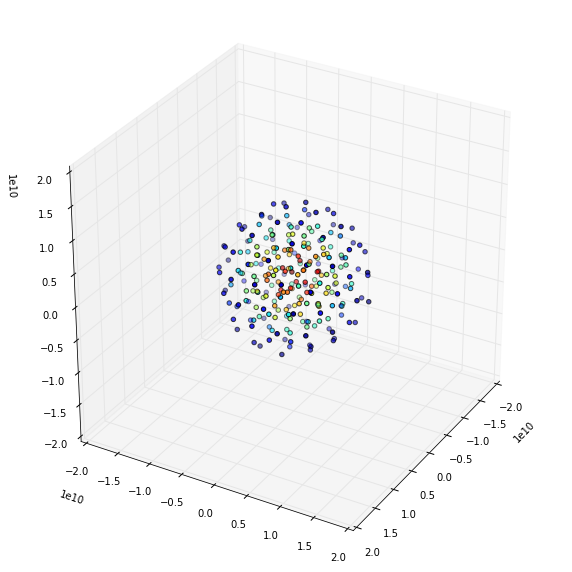

In [672]:
# slider = FloatSlider(description='Time', min=1, max=stepN, step=1)
# ParticlePositionHistory1=np.load('3d_data.csv.npy')

# def update_plot():
#     time1=int(slider.value)
#     x1 = ParticlePositionHistory1[time1-1,:,0]
#     y1 = ParticlePositionHistory1[time1-1,:,1]
#     z1 = ParticlePositionHistory1[time1-1,:,2]
#     figf = plt.figure(figsize=(10,10))
#     axf = figf.add_subplot(111, projection='3d')
#     axf.scatter(x1, y1, z1, c=ParticleRhoHistory[time1-1,:,:])
# #     fig = plt.figure(figsize=(10,10))
# #     plt.scatter(x, y)
#     plt.xlim(-2e10,2e10)
#     plt.ylim(-2e10,2e10)
#     axf.set_zlim(-2e10,2e10)
#     axf.azim=30

#     clear_output(True)

# slider.on_trait_change(update_plot, 'value')


# display(slider)
# update_plot()

### Load old data into a new XYZ distribution array and initialize some nonzero velocity distribution

In [692]:
xyzDistribution=np.load('3d_data.csv.npy')[699,:,:]
velocityDistribution=np.ones((nParticles,3), dtype='float')*250000000

### Run RK1 Again

In [693]:
# RK1 Parameters
t0 = time.time()
t = 0
dt = 1e2
stepN = 100

# Particle history
ParticlePositionHistory = np.zeros((stepN,nParticles,3))
ParticleRhoHistory = np.zeros((stepN, nParticles, 1))
xyzDistributionOld = np.copy(xyzDistribution)

# Force history
forceHistory = np.zeros((stepN, 3))
for i in range(stepN):
    if i % 1 == 0:
        print "Time step", i
    if i == 2:
        rhoOld = np.copy(rhoDistribution)
    deltaVf = np.zeros_like(xyzDistribution, dtype = np.float)
    
    t += 1
    ParticlePositionHistory[i,:,:] = xyzDistribution
    
    deltaVf += nb_gravity(xyzDistribution,i) 
#    print "\nAvg gravity", np.mean(deltaVf)
    forceHistory[i,0] = np.mean(abs(deltaVf))
    
    deltaVf -= -nb_gradP()/rhoDistribution[:,np.newaxis]
#    print "Avg gravity + pressure", np.mean(deltaVf)
    forceHistory[i,1] = np.mean(abs(deltaVf))

    #deltaVf +=  -v*velocityDistribution**1
#    print "Avg damping:", np.mean(velocityDistribution)    
    forceHistory[i,2] = np.mean(-v*velocityDistribution**1)

    
    velocityDistribution += dt*deltaVf    
    xyzDistribution += dt*velocityDistribution
    
    densityUpdate()
    ParticleRhoHistory[i,:,:] = rhoDistribution[:,np.newaxis]
    pressureDistribution = K*rhoDistribution**2

print(time.time()-t0)
#print(rhoDistribution-rhoOld)
#print(xyDistribution-xyDistributionOld) 


Time step 0
Time step 1
Time step 2
Time step 3
Time step 4
Time step 5
Time step 6
Time step 7
Time step 8
Time step 9
Time step 10
Time step 11
Time step 12
Time step 13
Time step 14
Time step 15
Time step 16
Time step 17
Time step 18
Time step 19
Time step 20
Time step 21
Time step 22
Time step 23
Time step 24
Time step 25
Time step 26
Time step 27
Time step 28
Time step 29
Time step 30
Time step 31
Time step 32
Time step 33
Time step 34
Time step 35
Time step 36
Time step 37
Time step 38
Time step 39
Time step 40
Time step 41
Time step 42
Time step 43
Time step 44
Time step 45
Time step 46
Time step 47
Time step 48
Time step 49
Time step 50
Time step 51
Time step 52
Time step 53
Time step 54
Time step 55
Time step 56
Time step 57
Time step 58
Time step 59
Time step 60
Time step 61
Time step 62
Time step 63
Time step 64
Time step 65
Time step 66
Time step 67
Time step 68
Time step 69
Time step 70
Time step 71
Time step 72
Time step 73
Time step 74
Time step 75
Time step 76
Time step

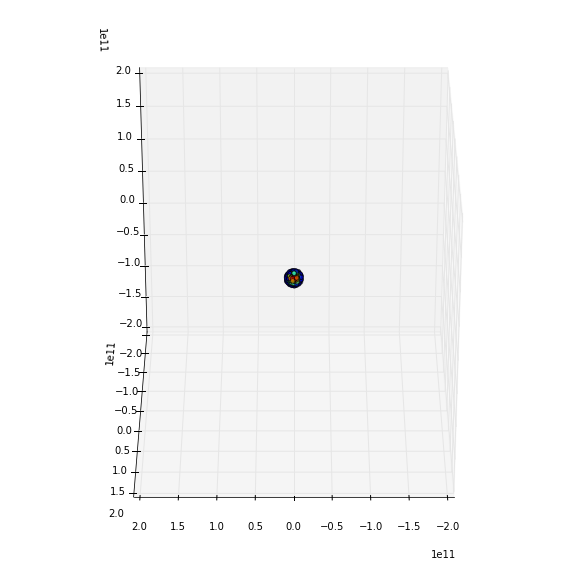

In [694]:
slider = FloatSlider(description='Time', min=1, max=stepN, step=1)

def update_plot():
    time=int(slider.value)
    x = ParticlePositionHistory[time-1,:,0]
    y = ParticlePositionHistory[time-1,:,1]
    z = ParticlePositionHistory[time-1,:,2]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=ParticleRhoHistory[time-1,:,:])
#     fig = plt.figure(figsize=(10,10))
#     plt.scatter(x, y)
    plt.xlim(-2e11,2e11)
    plt.ylim(-2e11,2e11)
    ax.set_zlim(-2e11,2e11)
    ax.azim=90

    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()